# Vision - Binary Image Classification

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of binary image classification with CNNs using the hot-dog/not-dog dataset on PyTorch.

In [221]:
import mlxtend
!pip install mlxtend --upgrade --no-deps

In [222]:
import os
import glob
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

In [223]:
np.random.seed(0)
torch.manual_seed(0)

In [224]:
%matplotlib inline
sns.set_style('darkgrid')

In [225]:
#from google.colab import drive
#drive.mount('/content/drive')

#!ls 

In [226]:
#cd  

## **CUIDAO!**

In [227]:
#os.rmdir('/home/jupyter/imagenes_entrenamiento_clasificador/train/.ipynb_checkpoints')

In [228]:
!ls -la '/home/jupyter/imagenes_entrenamiento_clasificador'

total 16
drwxr-xr-x  4 jupyter jupyter 4096 Jun 14 20:23 .
drwxr-xr-x 22 jupyter jupyter 4096 Jun 22 19:38 ..
drwxr-xr-x  4 jupyter jupyter 4096 Jun 14 20:25 test
drwxr-xr-x  4 jupyter jupyter 4096 Jun 14 20:25 train


In [229]:
!ls -la '/home/jupyter/imagenes_entrenamiento_clasificador/train'

total 7044
drwxr-xr-x 4 jupyter jupyter    4096 Jun 14 20:25 .
drwxr-xr-x 4 jupyter jupyter    4096 Jun 14 20:23 ..
drwxr-xr-x 2 jupyter jupyter 3887104 Jun 22 19:35 ataques_reales
drwxr-xr-x 2 jupyter jupyter 3309568 Jun 22 19:38 normal


In [230]:
!ls -la '/home/jupyter/imagenes_entrenamiento_clasificador/test'

total 5060
drwxr-xr-x 4 jupyter jupyter    4096 Jun 14 20:25 .
drwxr-xr-x 4 jupyter jupyter    4096 Jun 14 20:23 ..
drwxr-xr-x 2 jupyter jupyter 1855488 Jun 21 10:41 ataques_generados
drwxr-xr-x 2 jupyter jupyter 3309568 Jun 21 10:36 normal


## Define Paths and Set GPU

Let's define the path for our data.

In [231]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = '/home/jupyter/imagenes_entrenamiento_clasificador'
print("The data lies here =>", root_dir)

We're using => cpu
The data lies here => /home/jupyter/imagenes_entrenamiento_clasificador


## Define transforms

Let's define a dictionary to hold the image transformations for train/test sets. We will resize all images to have size (224, 224) as well as convert the images to tensor. The `ToTensor` operation in PyTorch convert all tensors to lie between (0, 1). 

> `ToTensor` converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

In [232]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((8, 8)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],
                             [0.5]) 
    ]),
    "test": transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((8, 8)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],
                             [0.5])
    ])
}

## Initialize Datasets

### Train + Validation Dataset

We 2 dataset folders with us - **Train** and **Test**. 

We will further divide our **Train** set as **Train + Val**. 

In [233]:
hotdog_dataset = datasets.ImageFolder(root = root_dir + "/train",
                                      transform = image_transforms["train"] ######################################################
                                     )

hotdog_dataset

Dataset ImageFolder
    Number of datapoints: 93200
    Root location: /home/jupyter/imagenes_entrenamiento_clasificador/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(8, 8), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

### Class <=> ID Mapping of Output

The `class_to_idx` function is pre-built in PyTorch. It returns class ID's present in the dataset.

In [234]:
hotdog_dataset.class_to_idx

{'ataques_reales': 0, 'normal': 1}

We will now construct a reverse of this dictionary; a mapping of ID to class. 

In [235]:
idx2class = {v: k for k, v in hotdog_dataset.class_to_idx.items()}

Let's also write a function that takes in a dataset object and returns a dictionary that contains the count of class samples. We will use this dictionary to contruct plots and observe the class distribution in our data.

`get_class_distribution()` takes in an argument called `dataset_obj`. 

* We first initialize a `count_dict` dictionary where counts of all classes are initialised to 0. 
* Then, let's iterate through the dataset and increment the counter by 1 for every class label encountered in the loop.


`plot_from_dict()` takes in 3 arguments: a dictionary called `dict_obj`, `plot_title`, and `**kwargs`. We pass in `**kwargs` because later on, we will constuct subplots which require passing the `ax` argument in seaborn. 

* First convert the dictionary to a dataframe. 
* Melt the dataframe and plot.

In [236]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

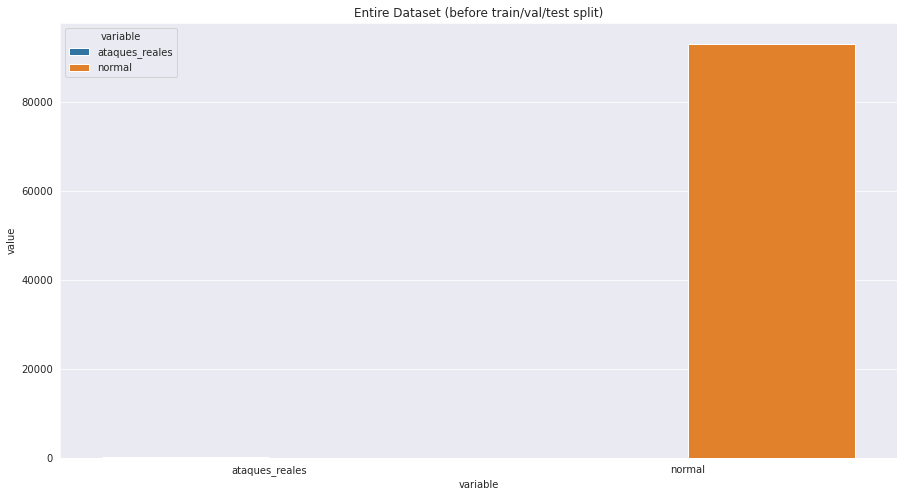

In [237]:
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(hotdog_dataset), plot_title="Entire Dataset (before train/val/test split)")

plt.savefig("/home/jupyter/modelo_clasificador_entrenado_graficas/dataset_entrenamiento.png")


### Get Train and Validation Samples

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes. 

We could've also split our dataset into 2 parts - train and val ie. make 2 `Subsets`. But this is simpler because our data loader will pretty much handle everything now.



`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

Create a list of indices from 0 to length of dataset.

In [238]:
hotdog_dataset_size = len(hotdog_dataset) # cuantos elementos tiene el dataset
hotdog_dataset_indices = list(range(hotdog_dataset_size)) # crear un array con numeros desde 0 hasta el numero de elementos del dataset

In [239]:
#hotdog_dataset_size 

In [240]:
#hotdog_dataset_indices

Shuffle the list of indices using np.shuffle.

In [241]:
np.random.shuffle(hotdog_dataset_indices) # se mezclan los indices de posicion para que no esten en orden

In [242]:
#hotdog_dataset_indices

Create the split index. We choose the split index to be 20% (0.2) of the dataset size.

In [243]:
val_split_index = int(np.floor(0.3 * hotdog_dataset_size)) # multiplica la longgitud total del dataset por 0,2 para ver cuantos indices coger para ser el 20%
                                                           # np.floor es para quedarte con la parte entera del numero multiplicado

In [244]:
#val_split_index

Slice the lists to obtain 2 lists of indices, one for train and other for test.

Val => 0 to val_split_index

Train => val_split_index to n


In [245]:
train_idx, val_idx = hotdog_dataset_indices[val_split_index:], hotdog_dataset_indices[:val_split_index] # de la lista de indices desordenados, coge el 20% para el test de validacion y el 80% para el train

In [246]:
#len(val_idx)

In [247]:
#val_idx

In [248]:
#len(train_idx)

In [249]:
#train_idx

Finally, create samplers.

In [250]:
train_sampler = SubsetRandomSampler(train_idx) #cada train sampler tiene una lista de indices aleatorios, el train sampler tiene el 80% de los indices y el val sampler el 20%
val_sampler = SubsetRandomSampler(val_idx)

### Test

Now that we're done with train and val data, let's load our test dataset. 

In [251]:
hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "/test",
                                            transform = image_transforms["test"]
                                           )

hotdog_dataset_test

Dataset ImageFolder
    Number of datapoints: 89050
    Root location: /home/jupyter/imagenes_entrenamiento_clasificador/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(8, 8), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [252]:
hotdog_dataset_test.class_to_idx

{'ataques_generados': 0, 'normal': 1}

## Train, Validation, and Test Dataloader

Now, we will pass the samplers to our dataloader. Note that `shuffle=True` cannot be used when you're using the `SubsetRandomSampler`.

In [253]:
train_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=False, batch_size=1)

## Explore The Data

To explore our train and val dataloaders, let's create a new function that takes in a dataloader and returns a dictionar with class counts. 

* Intialize a dictionary `count_dict` to all 0s.
* If the batch_size of the `dataloader_obj` is 1, then loop through the `dataloader_obj` and update the counter. 
* Else, if the batch_size of the `dataloader_obj` is **not** 1, then loop through the `dataloader_obj` to obtain batches. Loop through the batches to obtain individual tensors. Now, updated the counter accordingly. 

In [254]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
        
            
    return count_dict

To plot the class distributions, we will use the `plot_from_dict()` function defined earlier with the `ax` argument.

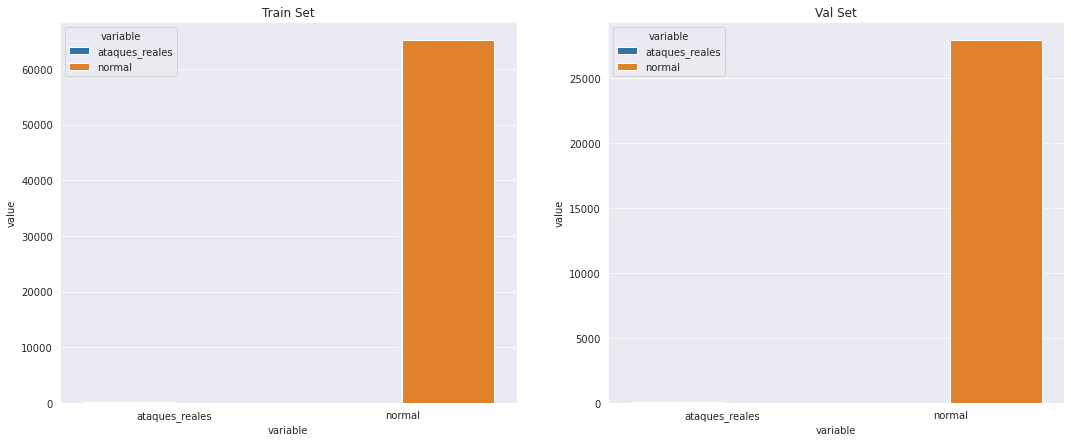

In [255]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

plot_from_dict(get_class_distribution_loaders(train_loader, hotdog_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, hotdog_dataset), plot_title="Val Set", ax=axes[1])

fig.savefig("/home/jupyter/modelo_clasificador_entrenado_graficas/dataset_train_val.png")

--------------------------------------------------------------------------------

Now that we've looked at the class distributions, Let's now look at a single image.

In [256]:
#single_batch = next(iter(train_loader))

`single_batch` is a list of 2 elements. The first element (0th index) contains the image tensors while the second element (1st index) contains the output labels. 

Here's the first element of the list which is a tensor. This tensor is of the shape `(batch, channels, height, width)`. 

In [257]:
# single_batch[0].shape

Here are the output labels for the batch.

In [258]:
#print("Output label tensors: ", single_batch[1])
#print("\nOutput label tensor shape: ", single_batch[1].shape)

To plot the image, we'll use `plt.imshow` from matloptlib. It expects the image dimension to be `(height, width, channels)`. We'll `.permute()` our single image tensor to plot it. 

In [259]:
# Selecting the first image tensor from the batch. 
#single_image = single_batch[0][0]
#single_image.shape

In [260]:
#plt.imshow(single_image.permute(1, 2))

PyTorch has made it easier for us to plot the images in a grid straight from the batch. 

We first extract out the image tensor from the list (returned by our dataloader) and set `nrow`. Then we use the `plt.imshow()` function to plot our grid. Remember to `.permute()` the tensor dimensions!

In [261]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
#single_batch_grid = utils.make_grid(single_batch[0], nrow=4)

In [262]:
#plt.figure(figsize = (10,10))
#plt.imshow(single_batch_grid.permute(1, 2, 0))

## Define a CNN Architecture

Our architecture is simple. We use 4 blocks of Conv layers. Each block consists of`Convolution` + `BatchNorm` + `ReLU` + `Dropout` layers.


We will not use an `FC` layer at the end. We'll stick with a `Conv` layer. 

In [263]:
class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        
        
        self.block1 = self.conv_block(c_in=1, c_out=64, kernel_size=3, stride=1, padding=1)
        self.block2 = self.conv_block(c_in=64, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block4 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block5 = self.conv_block(c_in=256, c_out=128, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=1, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
        x = self.maxpool(x)
    
        x = self.block3(x)
        x = self.block4(x)
        x = self.maxpool(x)
        
        x = self.block5(x)
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
#             nn.Dropout2d(p=dropout)
        )
        
        return seq_block        

Now we'll initialize the model, optimizer, and loss function. 

Then we'll transfer the model to GPU. 

We're using the `nn.CrossEntropyLoss` even though it's a binary classification problem. This means, instead of returning a single output of `1/0`, we'll treat return 2 values of `0 and 1`. More specifically, probabilities of the output being either `1` or `0`.

We don't have to manually apply a `log_softmax` layer after our final layer because `nn.CrossEntropyLoss` does that for us.

However, we need to apply `log_softmax` for our validation and testing.

In [264]:
model = HotDogClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

HotDogClassifier(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momen

Before we start our training, let's define a function to calculate accuracy per epoch. 

This function takes `y_pred` and `y_test` as input arguments. We then apply softmax to `y_pred` and extract the class which has a higher probability.

After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [265]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

We'll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

In [266]:
accuracy_stats = {
    'train': [],
}

loss_stats = {
    'train': [],
}

Let's TRAIN our model!

You can see we've put a `model.train()` at the before the loop. `model.train()` tells PyTorch that you're in training mode. Well, why do we need to do that? If you're using layers such as `Dropout` or `BatchNorm` which behave differently during training and evaluation (for eample; not use `dropout` during evalualtion), you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, so, you don't explicitly have to write that. But it's good practice.

Similarly, we'll call `model.eval()` when we test our model. We'll see that below. Back to training; we start a for-loop. At the top of this for-loop, we initialize our loss and accuracy per epoch to 0. After every epoch, we'll print out the loss/accuracy and reset it back to 0.

Then we have another for-loop. This for-loop is used to get our data in batches from the `train_loader`.

We do `optimizer.zero_grad()` before we make any predictions. Since the `.backward()` function accumulates gradients, we need to set it to 0 manually per mini-batch. From our defined model, we then obtain a prediction, get the loss(and accuracy) for that mini-batch, perform backpropagation using loss.backward() and optimizer.step().  


Finally, we add all the mini-batch losses (and accuracies) to obtain the average loss (and accuracy) for that epoch. We add up all the losses/accuracies for each minibatch and finally divide it by the number of minibatches ie. length of trainloader to obtain the average loss/accuracy per epoch.

The procedure we follow for training is the exact same for validation except for the fact that we wrap it up in `torch.no_grad` and not perform any backpropagation. `torch.no_grad()` tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.

# **ENTRENAMIENTO**

In [267]:
print("Begin training.")

n_epoch = 60

for e in tqdm(range(1, n_epoch+1)): # NUMERO DE EPOCH
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
           
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))


                              
    #print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(train_loader):.3f}')

    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')


Begin training.


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 0.02718 | Train Acc: 99.790
Epoch 02: | Train Loss: 0.00508 | Train Acc: 99.886
Epoch 03: | Train Loss: 0.00331 | Train Acc: 99.937
Epoch 04: | Train Loss: 0.00283 | Train Acc: 99.926
Epoch 05: | Train Loss: 0.00266 | Train Acc: 99.943
Epoch 06: | Train Loss: 0.00168 | Train Acc: 99.966
Epoch 07: | Train Loss: 0.00154 | Train Acc: 99.966
Epoch 08: | Train Loss: 0.00164 | Train Acc: 99.963
Epoch 09: | Train Loss: 0.00114 | Train Acc: 99.968
Epoch 10: | Train Loss: 0.00130 | Train Acc: 99.976
Epoch 11: | Train Loss: 0.00089 | Train Acc: 99.981
Epoch 12: | Train Loss: 0.00084 | Train Acc: 99.979
Epoch 13: | Train Loss: 0.00108 | Train Acc: 99.972
Epoch 14: | Train Loss: 0.00069 | Train Acc: 99.975
Epoch 15: | Train Loss: 0.00071 | Train Acc: 99.984
Epoch 16: | Train Loss: 0.00078 | Train Acc: 99.981
Epoch 17: | Train Loss: 0.00073 | Train Acc: 99.979
Epoch 18: | Train Loss: 0.00049 | Train Acc: 99.985
Epoch 19: | Train Loss: 0.00045 | Train Acc: 99.985
Epoch 20: | 

## Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the `accuracy_stats` and `loss_stats` dictionaries.

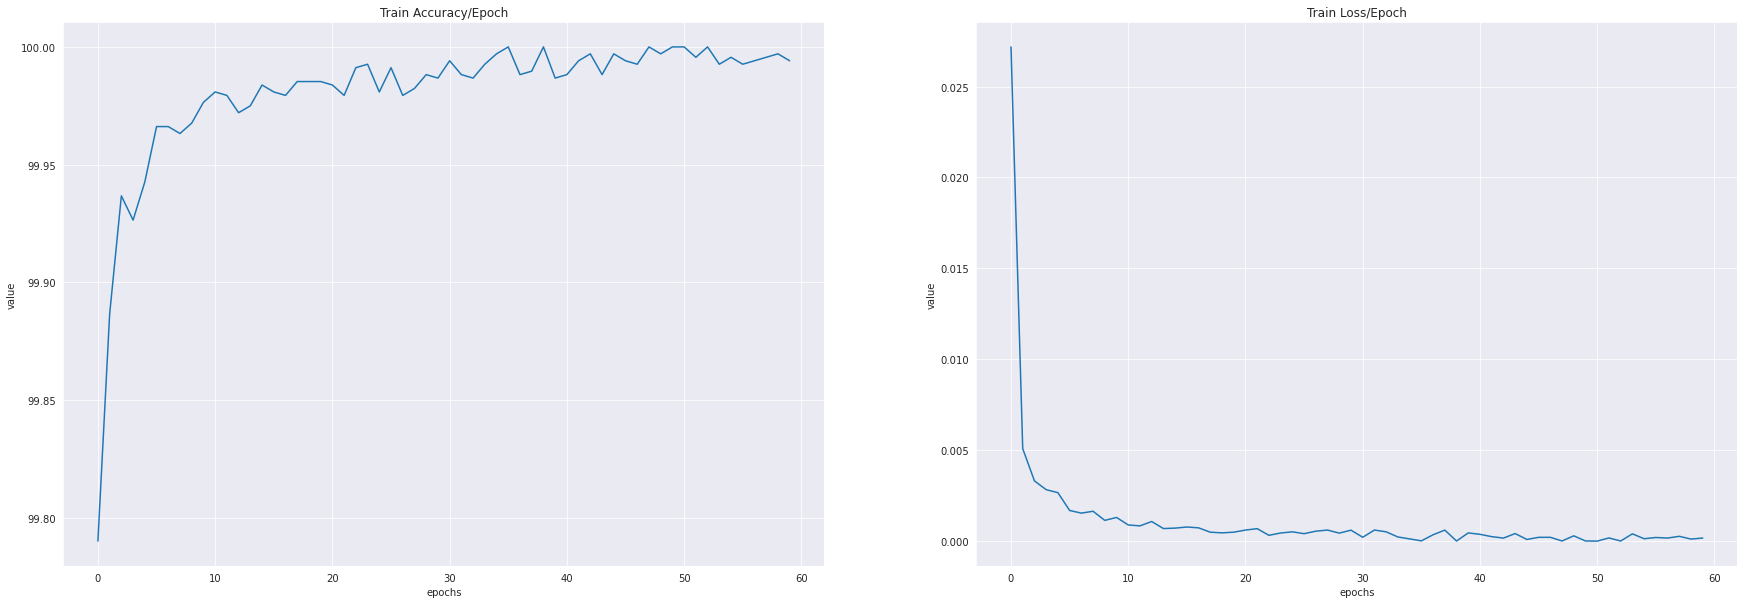

In [268]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats['train']).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats['train']).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value",  ax=axes[0]).set_title('Train Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", ax=axes[1]).set_title('Train Loss/Epoch')

fig.savefig('/home/jupyter/modelo_clasificador_entrenado_graficas/graficas_loss_accuracy.png')

# **GUARDAR / CARGAR CLASIFICADOR ENTRENADO**

In [269]:
ruta_modelos_clasificador = '/home/jupyter/modelo_clasificador_entrenado'

torch.save(model.state_dict(), ruta_modelos_clasificador + "/clasificador_60epoch_Exploits_desbalanceado93000-200.pt")

In [ ]:
ruta_modelos_clasificador = '/home/jupyter/modelo_clasificador_entrenado'

model.load_state_dict(torch.load(ruta_modelos_clasificador + "/clasificador_60epoch_EXPLOITS.pt"))

## Test

After training is done, we need to test how our model fared. Note that we've used `model.eval()` before we run our testing code.
To tell PyTorch that we do not want to perform back-propagation during inference, we use `torch.no_grad()`, just like we did it for the validation loop above.

* We start by defining a list that will hold our predictions. Then we loop through our batches using the `test_loader`. For each batch -
* We move our input mini-batch to GPU.
* We make the predictions using our trained model.
* Apply log_softmax activation to the predictions and pick the index of highest probability.
* Move the batch to the GPU from the CPU.
* Convert the tensor to a numpy object and append it to our list.

# **VALIDACION CLASIFICADOR**

In [270]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    model.eval()
    for x_batch, y_batch in tqdm(val_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

  0%|          | 0/27960 [00:00<?, ?it/s]

We'll flatten out the list so that we can use it as an input to `confusion_matrix` and `classification_report`.

In [271]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [272]:
clases = ['ataques_reales', 'normal']

print(classification_report(y_true_list, y_pred_list, target_names=clases, digits=7))

                precision    recall  f1-score   support

ataques_reales  0.9661017 0.9500000 0.9579832        60
        normal  0.9998925 0.9999283 0.9999104     27900

      accuracy                      0.9998212     27960
     macro avg  0.9829971 0.9749642 0.9789468     27960
  weighted avg  0.9998200 0.9998212 0.9998204     27960



# **MATRIZ CONFUSION**

In [273]:
print(confusion_matrix(y_true_list, y_pred_list))

[[   57     3]
 [    2 27898]]


In [274]:
#Función para representar la matriz de confusión.
def pintar_matriz (y_compare,pred):

  cm = metrics.confusion_matrix(y_compare, pred)
  plot_confusion_matrix(conf_mat=cm,figsize=(14,14), class_names=['ataques_reales', 'normal'], show_normed=True, colorbar=True)
  plt.title('Confusing Matrix')
  plt.ylabel('Target')
  plt.xlabel('Predicted')
  plt.savefig("/home/jupyter/modelo_clasificador_entrenado_graficas/matriz_confusion_validacion.png")
  plt.show()

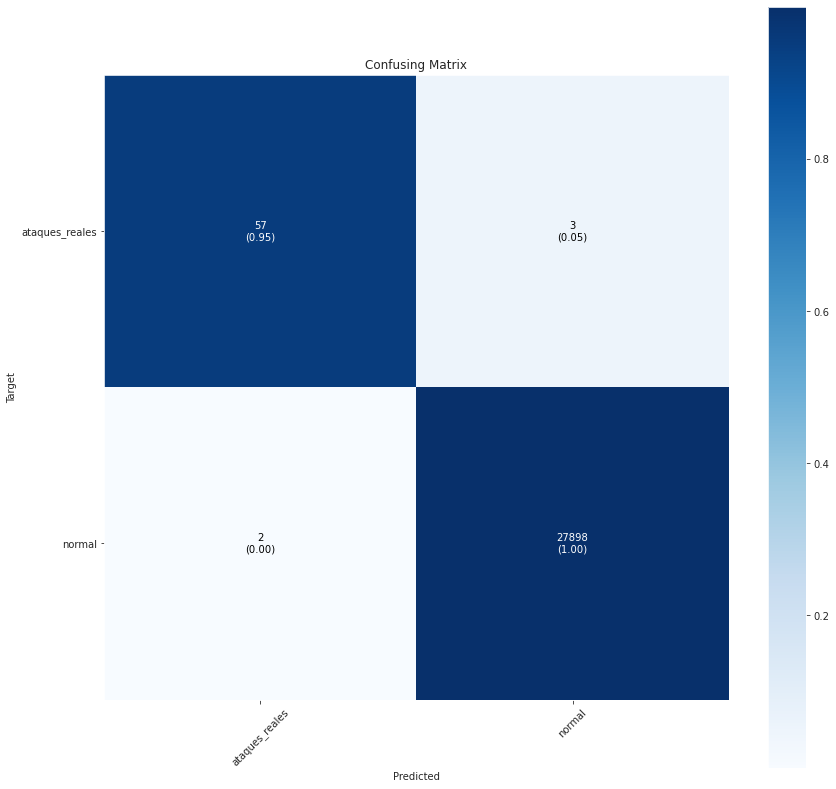

In [275]:
pintar_matriz(y_true_list,y_pred_list)

In [ ]:
!tar chvfz graficas_clasificador.tar.gz '/home/jupyter/modelo_clasificador_entrenado_graficas'

# **TEST**

In [ ]:
y_pred_list2 = []
y_true_list2 = []

with torch.no_grad():
    model.eval()
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list2.append(y_pred_tag.cpu().numpy())
        y_true_list2.append(y_batch.cpu().numpy())

In [ ]:
y_pred_list2 = [i[0][0][0] for i in y_pred_list2]
y_true_list2 = [i[0] for i in y_true_list2]

In [ ]:
hotdog_dataset_test.class_to_idx

In [ ]:
clases = ['ataques_generados', 'normal']

print(classification_report(y_true_list2, y_pred_list2, target_names=clases, digits=7))

# **MATRIZ CONFUSION**

In [ ]:
print(confusion_matrix(y_true_list2, y_pred_list2))

In [ ]:
#Función para representar la matriz de confusión.
def pintar_matriz (y_compare,pred):

  cm = metrics.confusion_matrix(y_compare, pred)
  plot_confusion_matrix(conf_mat=cm,figsize=(14,14), class_names=['ataques_generados', 'normal'], show_normed=True, colorbar=True)
  plt.title('Confusing Matrix')
  plt.ylabel('Target')
  plt.xlabel('Predicted')
  plt.savefig('/home/jupyter/graficas_entrenamiento_generador/matriz_confusion.png')
  plt.show()

In [ ]:
pintar_matriz(y_true_list2,y_pred_list2)

In [ ]:
!ls

In [ ]:
!tar chvfz ataques_generados.tar.gz '/home/jupyter/imagenes_entrenamiento_clasificador/test/ataques_generados'

In [ ]:
img_folder_path = '/home/jupyter/imagenes_entrenamiento_clasificador/test/ataques_generados'
dirListing = os.listdir(img_folder_path)

print(len(dirListing)) # cuantas imagenes hay en la carpeta

In [ ]:
files = glob.glob('/home/jupyter/imagenes_entrenamiento_clasificador/test/ataques_generados/*')

for f in files:
    os.remove(f)